## Long-short term memory (LSTM) network

Time series represent a feature rich source for modeling from which complex time-dependencies can be extracted. Several strategies for preparing time series data for machine learning exist. In perhaps the simplest approach, a window prior to an event is used and features extracted to produce tabular data. Oftentimes, these features are summary statistics that can be used to describe the distribution over the window of interest. While extracting these features can provide strong model performance, it limits the granularity of the data and can lose important trends. Recurrent Neural Networks (RNNs) are an class of deep learning models that are able to ingest temporal data to determine trends. Of specific interest are a type of recurrent neural network called a long short term memory (LSTM) network. LSTM networks are commonly composed of the following:
1. Cell: Processes values over some time window
2. Input Gate: which piece of new information is stored in the state
3. Output Gate: which piece of the information to output from the current state
4. Forget Gate: Decides what information to discard

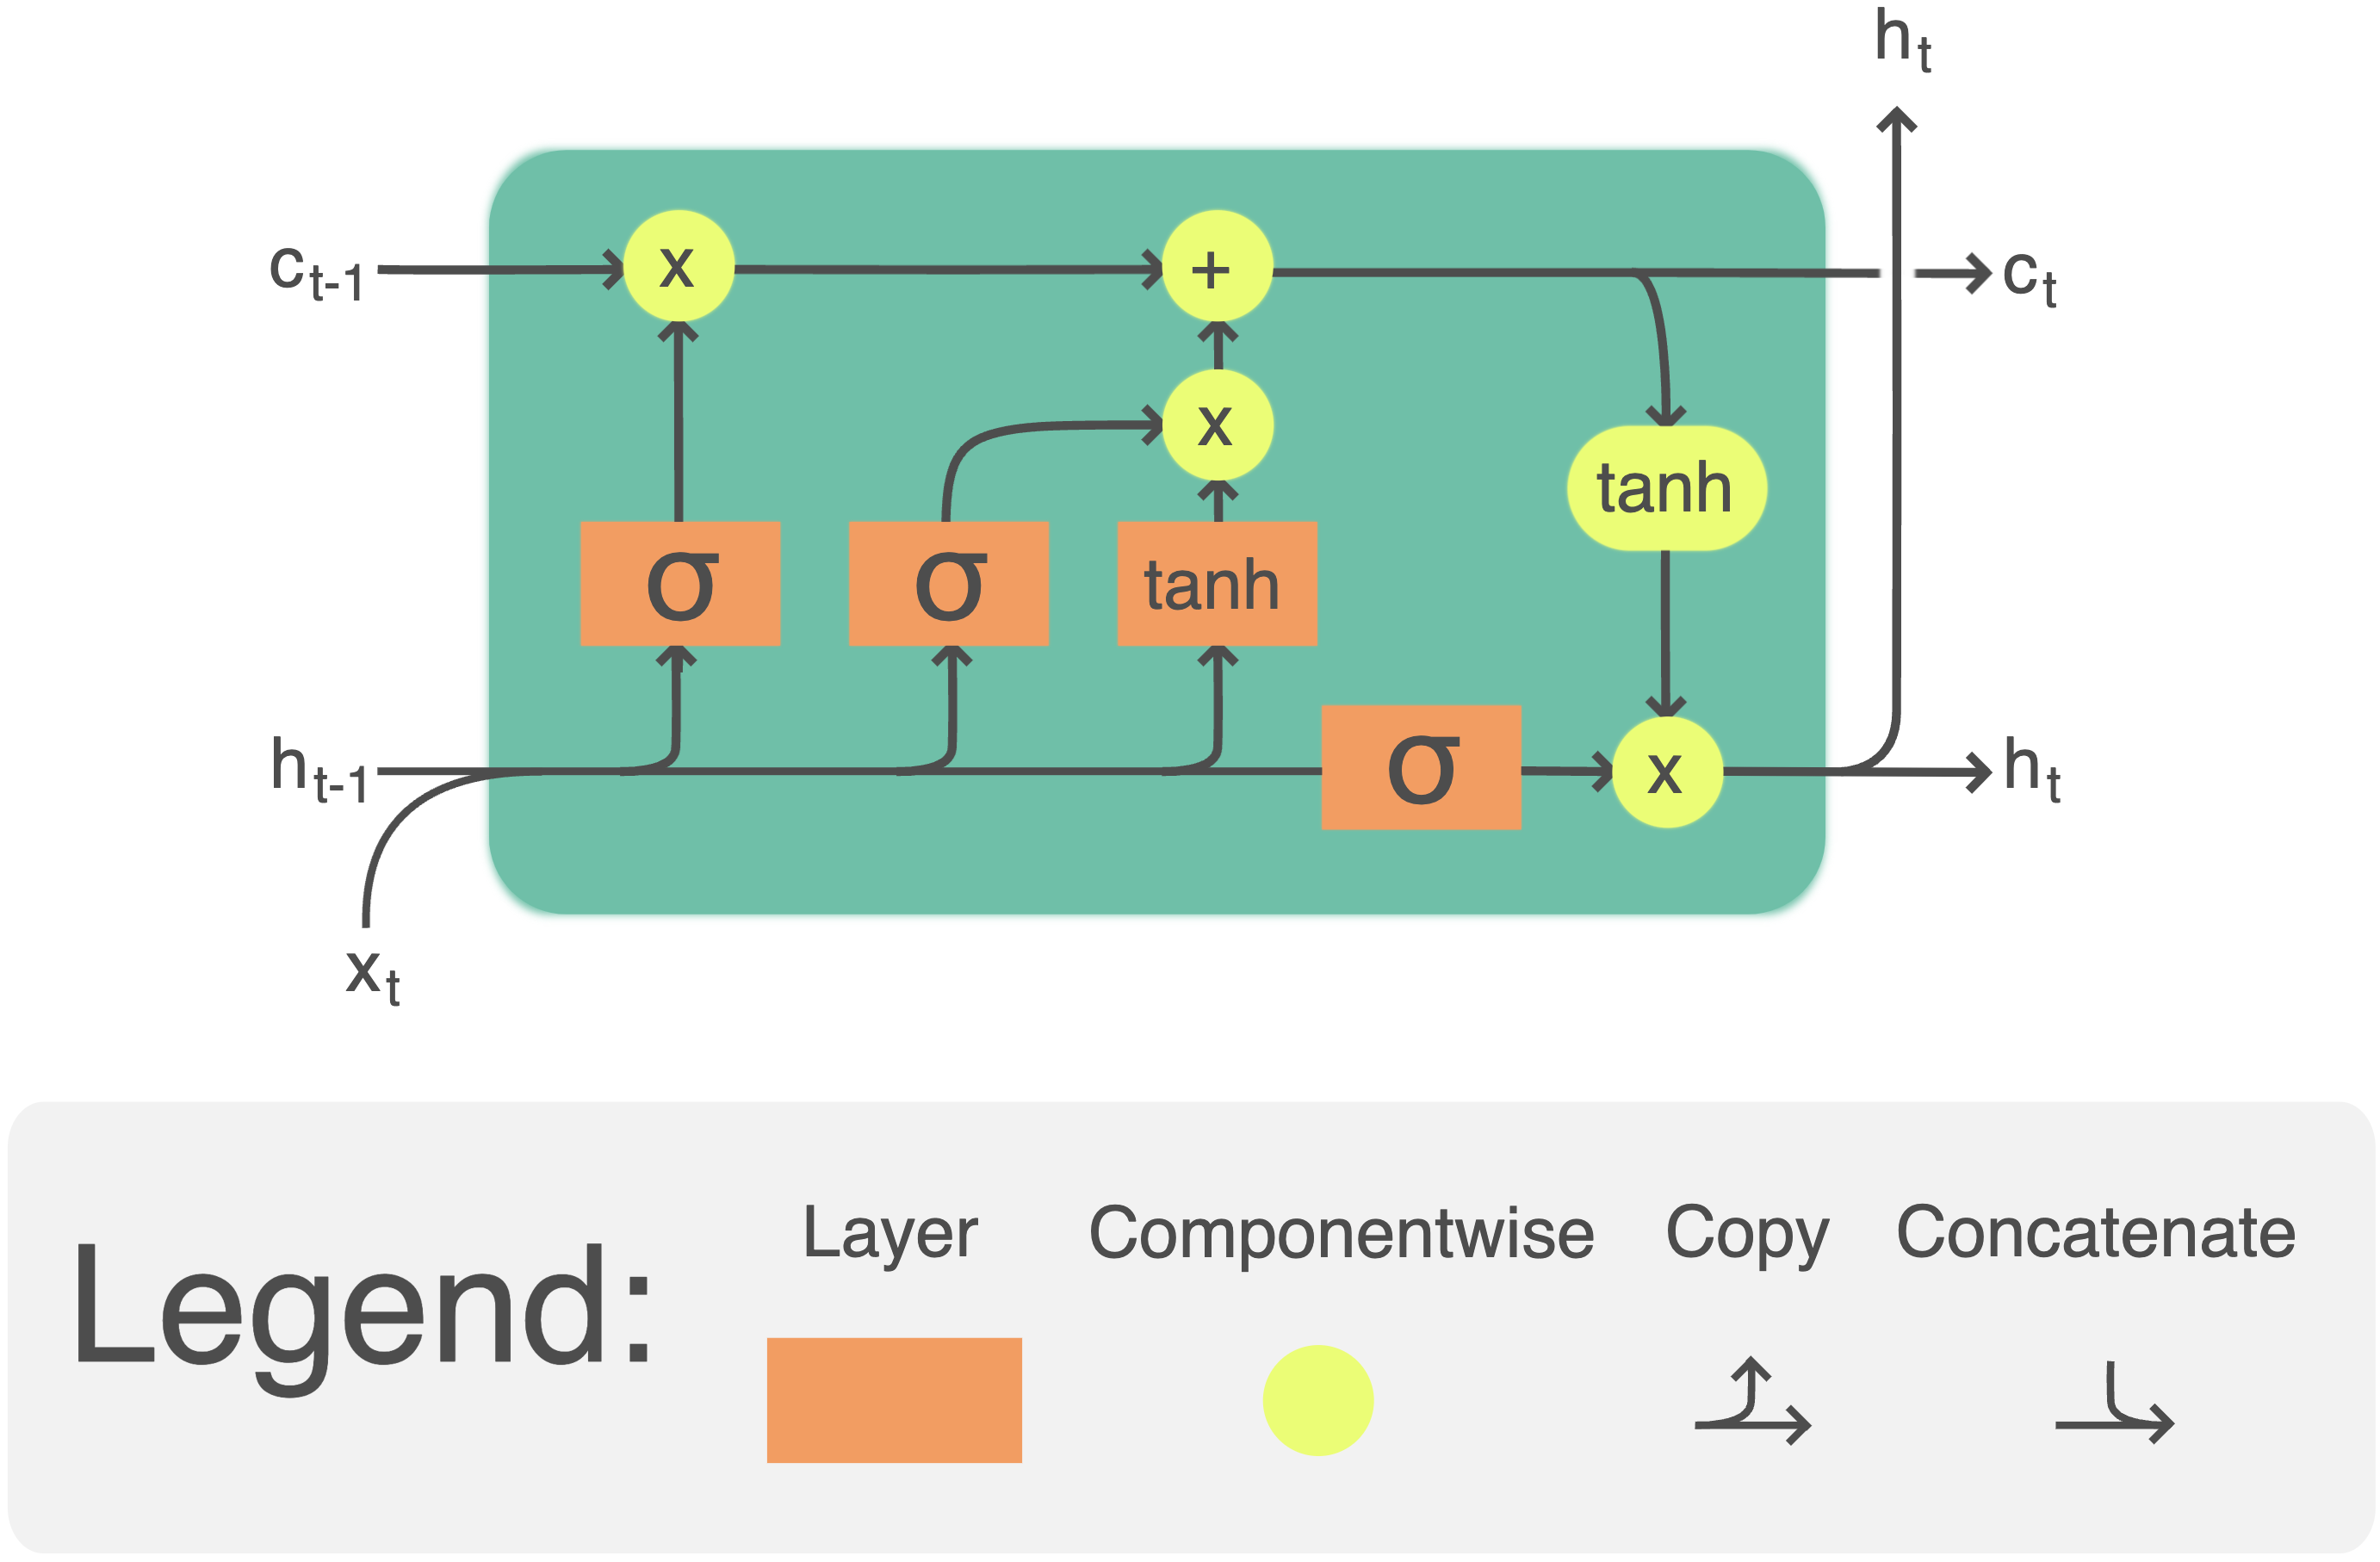

In [1]:
import pandas as pd
import os
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import to_categorical

2023-10-23 22:01:52.388519: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 22:01:52.678859: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 22:01:52.680560: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 22:01:54.459859: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# fit and evaluate a model
def evaluate_model(X_train, y_train, X_test, y_test):
    keras.backend.clear_session()
    verbose, epochs, batch_size = 1, 15, 64
    n_timesteps, n_features = X_train.shape[1], X_train.shape[2]
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features),return_sequences=True))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    return accuracy
 
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def run_experiment(X_train, y_train, X_test, y_test, repeats=10):
    # load data
    #trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(X_train, y_train, X_test, y_test)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

def load_data(input_df):
    
    array_list = list()
    target_list = list()
    for indx, row in input_df.iterrows():
        x0 = np.array(row['value_pad'])
        x1 = np.array(row['timedelta_pad'])
        array_list.append(np.column_stack([x0,x1]))
        target_list.append(row['readmit_flag'])
    
    return (np.array(array_list), np.array(target_list).reshape(-1,1))

In [3]:
os_platform = sys.platform

if os_platform == 'windows':
    RootDir = '\\'.join(os.getcwd().split('\\')[0:-2])
else:
    RootDir = '/'.join(os.getcwd().split('/')[0:-2])
os.chdir(RootDir)

In [4]:
%run "./notebooks/common/function_library.ipynb"

In [5]:
df_list = list()
for id in range(10):
    df_i = pd.read_csv('data/chartevents_{id}.csv.gz'.format(id=id),compression='gzip')
    df_list.append(df_i)
input_df = pd.concat(df_list)
input_df.reset_index(inplace=True,drop=True)
input_df

/tmp/ipykernel_22968/1801196300.py:3: DtypeWarning: Columns (4,5,13,20,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_i = pd.read_csv('data/chartevents_{id}.csv.gz'.format(id=id),compression='gzip')
/tmp/ipykernel_22968/1801196300.py:3: DtypeWarning: Columns (4,5,13,18,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_i = pd.read_csv('data/chartevents_{id}.csv.gz'.format(id=id),compression='gzip')
/tmp/ipykernel_22968/1801196300.py:3: DtypeWarning: Columns (4,5,13,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_i = pd.read_csv('data/chartevents_{id}.csv.gz'.format(id=id),compression='gzip')
/tmp/ipykernel_22968/1801196300.py:3: DtypeWarning: Columns (4,5,6,13,18,47) have mixed types. Specify dtype option on import or set low_memory=False.
  df_i = pd.read_csv('data/chartevents_{id}.csv.gz'.format(id=id),compression='gzip')
/tmp/ipykernel_22968/1801196300.py:3: DtypeWarning: Columns (

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id.1,subject_id.1,...,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
0,3335,3529,M,2199-04-20 00:00:00.000,NaN,NaN,NaN,0,4254,3529,...,2199-04-20 01:30:00.000,2199-04-20 01:34:00.000,17581,158.0,158.0,bpm,NaN,NaN,NaN,NotStopd
1,13569,14349,M,2157-12-27 00:00:00.000,NaN,NaN,NaN,0,17581,14349,...,2157-12-30 00:00:00.000,2157-12-29 23:58:00.000,20262,135.0,135.0,bpm,NaN,NaN,NaN,NotStopd
2,13569,14349,M,2157-12-27 00:00:00.000,NaN,NaN,NaN,0,17581,14349,...,2157-12-29 23:00:00.000,2157-12-29 22:20:00.000,20262,135.0,135.0,bpm,NaN,NaN,NaN,NotStopd
3,13569,14349,M,2157-12-27 00:00:00.000,NaN,NaN,NaN,0,17581,14349,...,2157-12-29 22:00:00.000,2157-12-29 22:20:00.000,20262,124.0,124.0,bpm,NaN,NaN,NaN,NotStopd
4,13569,14349,M,2157-12-27 00:00:00.000,NaN,NaN,NaN,0,17581,14349,...,2157-12-28 09:00:00.000,2157-12-28 08:45:00.000,16433,127.0,127.0,bpm,NaN,NaN,NaN,NotStopd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702894,23258,24648,F,2200-11-02 00:00:00.000,NaN,NaN,NaN,0,30099,24648,...,2200-11-02 15:00:00.000,2200-11-02 15:36:00.000,17125,146.0,146.0,bpm,NaN,NaN,NaN,NotStopd
1702895,23258,24648,F,2200-11-02 00:00:00.000,NaN,NaN,NaN,0,30099,24648,...,2200-11-02 14:00:00.000,2200-11-02 14:00:00.000,17125,130.0,130.0,bpm,NaN,NaN,NaN,NotStopd
1702896,23258,24648,F,2200-11-02 00:00:00.000,NaN,NaN,NaN,0,30099,24648,...,2200-11-02 13:00:00.000,2200-11-02 13:29:00.000,17125,122.0,122.0,bpm,NaN,NaN,NaN,NotStopd
1702897,23258,24648,F,2200-11-02 00:00:00.000,NaN,NaN,NaN,0,30099,24648,...,2200-11-02 12:30:00.000,2200-11-02 12:31:00.000,18246,117.0,117.0,bpm,NaN,NaN,NaN,NotStopd


In [6]:
time_df = input_df[['subject_id','hadm_id','itemid','charttime','value','valueuom']].sort_values(['hadm_id','charttime'])
time_df = time_df[time_df['itemid']==211]
time_df['charttime'] = time_df['charttime'].astype('datetime64[ns]')
time_df

,subject_id,hadm_id,itemid,charttime,value,valueuom
243116,1189,100023,211,2130-05-28 06:45:00,132.0,bpm
243115,1189,100023,211,2130-05-28 08:30:00,114.0,bpm
1162953,4528,100025,211,2191-07-13 12:00:00,144.0,bpm
1162926,4528,100025,211,2191-07-13 13:00:00,124.0,bpm
1162925,4528,100025,211,2191-07-13 14:00:00,126.0,bpm
...,...,...,...,...,...,...
613317,25768,199918,211,2111-05-28 02:30:00,154.0,bpm
613374,25768,199918,211,2111-05-28 07:00:00,148.0,bpm
613373,25768,199918,211,2111-05-28 10:30:00,156.0,bpm
901914,13446,199954,211,2120-11-08 12:00:00,142.0,bpm


In [7]:
count_df = time_df.groupby('hadm_id',as_index=False).agg({'value':'count'})
adm_list = count_df[count_df['value']>4]['hadm_id'].tolist()

In [8]:
time_df = time_df[time_df['hadm_id'].isin(adm_list)].reset_index()

In [9]:
def f_diff(t0, t1):
    return t1 - t0

t_df = time_df.groupby('hadm_id').apply(lambda x: f_diff(x.charttime.shift(), x.charttime)).reset_index(drop=True)

In [10]:
time_df['timedelta'] = t_df.tolist()
time_df['timedelta'] = time_df['timedelta'].fillna(pd.Timedelta(seconds=0))
time_df

,index,subject_id,hadm_id,itemid,charttime,value,valueuom,timedelta
0,1162953,4528,100025,211,2191-07-13 12:00:00,144.0,bpm,0 days 00:00:00
1,1162926,4528,100025,211,2191-07-13 13:00:00,124.0,bpm,0 days 01:00:00
2,1162925,4528,100025,211,2191-07-13 14:00:00,126.0,bpm,0 days 01:00:00
3,1162924,4528,100025,211,2191-07-13 15:00:00,119.0,bpm,0 days 01:00:00
4,1162937,4528,100025,211,2191-07-13 16:00:00,125.0,bpm,0 days 01:00:00
...,...,...,...,...,...,...,...,...
1692982,613277,25768,199918,211,2111-05-27 19:30:00,158.0,bpm,0 days 00:30:00
1692983,613318,25768,199918,211,2111-05-27 22:30:00,164.0,bpm,0 days 03:00:00
1692984,613317,25768,199918,211,2111-05-28 02:30:00,154.0,bpm,0 days 04:00:00
1692985,613374,25768,199918,211,2111-05-28 07:00:00,148.0,bpm,0 days 04:30:00


In [11]:
time_df['timedelta'] = time_df['timedelta'].astype('int64') / 3600000000000 # convert to hours

In [12]:
mx = MinMaxScaler()
time_df['value'] = mx.fit_transform(time_df['value'].values.reshape(-1,1))

mx = MinMaxScaler()
time_df['timedelta'] = mx.fit_transform(time_df['timedelta'].values.reshape(-1,1))

time_df

,index,subject_id,hadm_id,itemid,charttime,value,valueuom,timedelta
0,1162953,4528,100025,211,2191-07-13 12:00:00,0.480000,bpm,0.000000
1,1162926,4528,100025,211,2191-07-13 13:00:00,0.413333,bpm,0.000922
2,1162925,4528,100025,211,2191-07-13 14:00:00,0.420000,bpm,0.000922
3,1162924,4528,100025,211,2191-07-13 15:00:00,0.396667,bpm,0.000922
4,1162937,4528,100025,211,2191-07-13 16:00:00,0.416667,bpm,0.000922
...,...,...,...,...,...,...,...,...
1692982,613277,25768,199918,211,2111-05-27 19:30:00,0.526667,bpm,0.000461
1692983,613318,25768,199918,211,2111-05-27 22:30:00,0.546667,bpm,0.002765
1692984,613317,25768,199918,211,2111-05-28 02:30:00,0.513333,bpm,0.003687
1692985,613374,25768,199918,211,2111-05-28 07:00:00,0.493333,bpm,0.004147


In [13]:
time_df.groupby('hadm_id',as_index=False).agg({'value':'count'}).median()

hadm_id    148982.0
value         165.0
dtype: float64

In [14]:
def pad_array(x0, cutoff=165):
    x_new = np.zeros(cutoff)
    n = np.min([cutoff, len(x0)])
    i = cutoff - n
    ii = len(x0) - n
    x_new[i:] = x0[ii:]
    return x_new

In [15]:
group_df = time_df.groupby('hadm_id', as_index=False).agg({'value':list, 'timedelta':list})
group_df

,hadm_id,value,timedelta
0,100025,"[0.48000000000000004, 0.4133333333333334, 0.42...","[0.0, 0.0009216589861751152, 0.000921658986175..."
1,100029,"[0.5133333333333334, 0.4666666666666667, 0.493...","[0.0, 0.0009216589861751152, 0.000921658986175..."
2,100044,"[0.5133333333333334, 0.4066666666666667, 0.5, ...","[0.0, 0.0007219662058371736, 0.000921658986175..."
3,100055,"[0.4666666666666667, 0.4666666666666667, 0.53,...","[0.0, 0.0, 0.0004608294930875576, 0.0, 0.00046..."
4,100062,"[0.52, 0.5133333333333334, 0.5133333333333334,...","[0.0, 0.0006912442396313364, 0.000230414746543..."
...,...,...,...
4549,199901,"[0.48333333333333334, 0.47000000000000003, 0.4...","[0.0, 0.0009216589861751152, 0.000921658986175..."
4550,199904,"[0.46, 0.4866666666666667, 0.5133333333333334,...","[0.0, 0.0002304147465437788, 0.000460829493087..."
4551,199913,"[0.5566666666666668, 0.5, 0.55, 0.516666666666...","[0.0, 0.0006912442396313364, 0.000921658986175..."
4552,199917,"[0.5933333333333334, 0.48000000000000004, 0.48...","[0.0, 0.0009216589861751152, 0.000921658986175..."


In [16]:
group_df['value_pad'] = group_df.value.apply(lambda x: pad_array(x, cutoff=165))
group_df['timedelta_pad'] = group_df.timedelta.apply(lambda x: pad_array(x, cutoff=165))

In [17]:
group_df.reset_index(drop=True,inplace=True)
group_df

,hadm_id,value,timedelta,value_pad,timedelta_pad
0,100025,"[0.48000000000000004, 0.4133333333333334, 0.42...","[0.0, 0.0009216589861751152, 0.000921658986175...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,100029,"[0.5133333333333334, 0.4666666666666667, 0.493...","[0.0, 0.0009216589861751152, 0.000921658986175...","[0.4466666666666667, 0.4666666666666667, 0.426...","[0.0009216589861751152, 0.0009216589861751152,..."
2,100044,"[0.5133333333333334, 0.4066666666666667, 0.5, ...","[0.0, 0.0007219662058371736, 0.000921658986175...","[0.48000000000000004, 0.5233333333333333, 0.54...","[0.0009216589861751152, 0.0009216589861751152,..."
3,100055,"[0.4666666666666667, 0.4666666666666667, 0.53,...","[0.0, 0.0, 0.0004608294930875576, 0.0, 0.00046...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,100062,"[0.52, 0.5133333333333334, 0.5133333333333334,...","[0.0, 0.0006912442396313364, 0.000230414746543...","[0.5, 0.5166666666666667, 0.5066666666666667, ...","[0.0002304147465437788, 0.0002304147465437788,..."
...,...,...,...,...,...
4549,199901,"[0.48333333333333334, 0.47000000000000003, 0.4...","[0.0, 0.0009216589861751152, 0.000921658986175...","[0.5266666666666667, 0.49333333333333335, 0.5,...","[0.0009216589861751152, 0.0009216589861751152,..."
4550,199904,"[0.46, 0.4866666666666667, 0.5133333333333334,...","[0.0, 0.0002304147465437788, 0.000460829493087...","[0.49333333333333335, 0.5166666666666667, 0.51...","[0.0009216589861751152, 0.0009216589861751152,..."
4551,199913,"[0.5566666666666668, 0.5, 0.55, 0.516666666666...","[0.0, 0.0006912442396313364, 0.000921658986175...","[0.42333333333333334, 0.4366666666666667, 0.45...","[0.0004608294930875576, 0.0009216589861751152,..."
4552,199917,"[0.5933333333333334, 0.48000000000000004, 0.48...","[0.0, 0.0009216589861751152, 0.000921658986175...","[0.41000000000000003, 0.4766666666666667, 0.39...","[0.0009216589861751152, 0.0009216589861751152,..."


In [18]:
label_df = pd.read_csv('data/labels.csv')
label_df 

,subject_id,subject_id.1,hadm_id,readmit_flag,dischtime
0,2,2.0,163353,0,2138-07-21 15:48:00.000
1,5,NaN,178980,0,2103-02-04 12:15:00.000
2,7,NaN,118037,1,2121-05-27 11:57:00.000
3,7,NaN,118037,0,2121-05-27 11:57:00.000
4,8,8.0,159514,0,2117-11-24 14:20:00.000
...,...,...,...,...,...
8095,32799,NaN,116323,0,2164-02-19 15:30:00.000
8096,32801,32801.0,158613,0,2191-04-08 22:55:00.000
8097,32802,NaN,128876,0,2126-01-30 15:05:00.000
8098,32803,32803.0,105824,0,2118-06-25 15:00:00.000


In [19]:
merge_df = pd.merge(group_df, label_df, on='hadm_id', how='inner')
merge_df

,hadm_id,value,timedelta,value_pad,timedelta_pad,subject_id,subject_id.1,readmit_flag,dischtime
0,100025,"[0.48000000000000004, 0.4133333333333334, 0.42...","[0.0, 0.0009216589861751152, 0.000921658986175...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4528,NaN,0,2191-07-15 22:16:00.000
1,100029,"[0.5133333333333334, 0.4666666666666667, 0.493...","[0.0, 0.0009216589861751152, 0.000921658986175...","[0.4466666666666667, 0.4666666666666667, 0.426...","[0.0009216589861751152, 0.0009216589861751152,...",14509,14509.0,0,2185-05-02 12:00:00.000
2,100044,"[0.5133333333333334, 0.4066666666666667, 0.5, ...","[0.0, 0.0007219662058371736, 0.000921658986175...","[0.48000000000000004, 0.5233333333333333, 0.54...","[0.0009216589861751152, 0.0009216589861751152,...",677,677.0,0,2195-09-14 10:50:00.000
3,100055,"[0.4666666666666667, 0.4666666666666667, 0.53,...","[0.0, 0.0, 0.0004608294930875576, 0.0, 0.00046...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1549,1549.0,1,2150-07-10 16:14:00.000
4,100055,"[0.4666666666666667, 0.4666666666666667, 0.53,...","[0.0, 0.0, 0.0004608294930875576, 0.0, 0.00046...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1549,1549.0,0,2150-07-10 16:14:00.000
...,...,...,...,...,...,...,...,...,...
4636,199901,"[0.48333333333333334, 0.47000000000000003, 0.4...","[0.0, 0.0009216589861751152, 0.000921658986175...","[0.5266666666666667, 0.49333333333333335, 0.5,...","[0.0009216589861751152, 0.0009216589861751152,...",4440,4440.0,0,2173-04-16 14:40:00.000
4637,199904,"[0.46, 0.4866666666666667, 0.5133333333333334,...","[0.0, 0.0002304147465437788, 0.000460829493087...","[0.49333333333333335, 0.5166666666666667, 0.51...","[0.0009216589861751152, 0.0009216589861751152,...",21938,21938.0,0,2184-04-14 16:30:00.000
4638,199913,"[0.5566666666666668, 0.5, 0.55, 0.516666666666...","[0.0, 0.0006912442396313364, 0.000921658986175...","[0.42333333333333334, 0.4366666666666667, 0.45...","[0.0004608294930875576, 0.0009216589861751152,...",13756,13756.0,0,2198-01-06 18:45:00.000
4639,199917,"[0.5933333333333334, 0.48000000000000004, 0.48...","[0.0, 0.0009216589861751152, 0.000921658986175...","[0.41000000000000003, 0.4766666666666667, 0.39...","[0.0009216589861751152, 0.0009216589861751152,...",3077,3077.0,0,2113-02-08 14:15:00.000


In [20]:
train_df, test_df = train_test_split(merge_df[['value_pad','timedelta_pad','readmit_flag']],test_size=0.4,random_state=42, stratify=merge_df['readmit_flag'].tolist())

In [21]:
X_train, y_train = load_data(train_df)
X_test, y_test = load_data(test_df)

In [22]:
X_train = np.nan_to_num(X_train, nan=0, posinf=1.1)

In [23]:
y_train.shape

(2784, 1)

In [24]:
run_experiment(X_train, y_train, X_test, y_test, repeats=10)

2023-10-23 22:02:42.561627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-23 22:02:42.564557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-23 22:02:42.566504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/15


2023-10-23 22:02:43.106432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-23 22:02:43.108841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-23 22:02:43.110554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

44/44 [==============================] - 11s 181ms/step - loss: 0.2728 - accuracy: 0.9661
Epoch 2/15
44/44 [==============================] - 8s 186ms/step - loss: 0.1503 - accuracy: 0.9705
Epoch 3/15
44/44 [==============================] - 8s 178ms/step - loss: 0.1465 - accuracy: 0.9705
Epoch 4/15
44/44 [==============================] - 8s 188ms/step - loss: 0.1440 - accuracy: 0.9705
Epoch 5/15
44/44 [==============================] - 8s 180ms/step - loss: 0.1432 - accuracy: 0.9705
Epoch 6/15
44/44 [==============================] - 8s 185ms/step - loss: 0.1408 - accuracy: 0.9705
Epoch 7/15
44/44 [==============================] - 8s 179ms/step - loss: 0.1405 - accuracy: 0.9705
Epoch 8/15
44/44 [==============================] - 8s 188ms/step - loss: 0.1389 - accuracy: 0.9705
Epoch 9/15
44/44 [==============================] - 8s 180ms/step - loss: 0.1380 - accuracy: 0.9705
Epoch 10/15
44/44 [==============================] - 8s 188ms/step - loss: 0.1386 - accuracy: 0.9705
Epoch 11/

2023-10-23 22:05:07.506033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-23 22:05:07.508508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-10-23 22:05:07.510265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

>#1: 97.092


KeyboardInterrupt: 